**1.Importation des bibliothèques.**

Dans cette section, nous importons les bibliothèques nécessaires à notre solution

In [1]:
import random
import time
import time
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict

**2.Declaration des structures .**

Nous entamons la déclaration des structures nécessaires à la solution, à savoir Bin et Item.

In [2]:
class Bin:
    def __init__(self, capacity):
        self.capacity = capacity
        self.items = []

    def remaining_capacity(self):
        return self.capacity - sum(self.items)

class Item:
    def __init__(self, size):
        self.size = size

**3.Algorithm principale ACO :**

1. **Initialisation** : Initialise la meilleure solution à None et le meilleur score à l'infini.
2. **Boucle principale** : Pour un nombre d'itérations défini, répète les étapes suivantes :
    1. **Initialisation des phéromones** : Initialise la matrice de phéromones avec une valeur de départ.
    2. **Construction des solutions** : Pour un nombre d'agents (fourmis) donné, construit une solution en utilisant la méthode de construction, puis évalue la solution.
    3. **Mise à jour de la meilleure solution** : Si la nouvelle solution est meilleure que la meilleure solution actuelle, met à jour la meilleure solution et son score.
    4. **Mise à jour des phéromones** : Met à jour les phéromones en fonction des solutions construites.
3. **Retourne** : Retourne la meilleure solution trouvée et son score.

In [3]:
def aco_bin_packing(items, bin_capacity, num_ants, num_iterations, evaporation_rate, alpha, beta):
    best_solution = None
    best_score = float('inf')
    max_item_size = max([item.size for item in items])
    for _ in range(num_iterations):

        pheromone_matrix = [[0.3] * (max_item_size + 1) for _ in range(max_item_size + 1)]

        for _ in range(num_ants):
            solution = construct_solution(items, bin_capacity, pheromone_matrix, alpha, beta)
            score = evaluate_solution(solution)
            if score < best_score:
                best_solution = solution
                best_score = score
            update_pheromones(pheromone_matrix, solution, evaporation_rate)
    return best_solution, best_score

**4.Construction de la solution:**

Cette fonction construit une solution en plaçant itérativement des articles dans des bacs jusqu'à ce que tous les articles soient alloués. Voici une explication des étapes impliquées :

1. **Initialisation** : Initialise une liste de bacs avec un seul bac de la capacité donnée.
2. **Boucle** : Tant qu'il reste des articles à allouer :
    1. **Calcul des Probabilités** : Calcule les probabilités de choisir chaque article en fonction des niveaux de phéromones et des informations heuristiques.
    2. **Choix de l'Article** : Sélectionne de manière aléatoire un article en fonction des probabilités calculées.
    3. **Placement de l'Article dans le Bac** : Parcourt les bacs et tente de placer l'article choisi dans le premier bac ayant une capacité suffisante.
    4. **Création d'un Nouveau Bac si Nécessaire** : Si aucun bac n'a une capacité suffisante, crée un nouveau bac et place l'article dedans.
    5. **Suppression de l'Article** : Supprime l'article choisi de la liste des articles restants.
8. **Retourne la Solution** : Retourne la liste des bacs représentant la solution construite.

In [4]:
def construct_solution(items, bin_capacity, pheromone_matrix, alpha, beta):
    bins = [Bin(bin_capacity)]
    remaining_items = items[:]
    while remaining_items:
        probabilities = calculate_probabilities(bins, remaining_items, pheromone_matrix, alpha, beta)
        chosen_item = random.choices(remaining_items, probabilities)[0]

        for bin in bins:
            if bin.remaining_capacity() >= chosen_item.size:
                bin.items.append(chosen_item.size)
                remaining_items.remove(chosen_item)
                break
        else:
            new_bin = Bin(bin_capacity)
            new_bin.items.append(chosen_item.size)
            bins.append(new_bin)
            remaining_items.remove(chosen_item)
    return bins

**5.Calculer les probabilités:**

Cette fonction calcule les probabilités de choisir chaque article pour l'ajouter au prochain bac, en tenant compte des niveaux de phéromones et des informations heuristiques. Voici comment elle fonctionne :

1. Elle itère sur chaque article restant à placer dans un bac.
   1. Pour chaque article, elle calcule son attractivité, qui est définie comme l'inverse de sa taille.
   2. Elle vérifie d'abord si le dernier bac a des articles avant d'y accéder.
   3. Si le dernier bac contient des articles, elle calcule la somme pondérée des niveaux de phéromones et de l'attractivité de l'article actuel par rapport au dernier article du dernier bac.
   4. Si le dernier bac est vide, elle utilise une valeur par défaut pour la mise à jour des phéromones.
   5. Ensuite, elle normalise les probabilités en divisant chaque probabilité par la somme totale des probabilités.
7. Elle retourne la liste des probabilités calculées pour chaque article.

In [5]:
def calculate_probabilities(bins, items, pheromone_matrix, alpha, beta):
  probabilities = []
  total = 0
  for item in items:

    attractiveness = 1 / item.size
    # Check if the last bin has any items before accessing them
    if bins[-1].items:
      last_item_index = len(bins[-1].items) - 1
      total += (pheromone_matrix[bins[-1].items[last_item_index]][item.size - 1] ** alpha) * (attractiveness ** beta)
    else:
      # If the bin is empty, there's no pheromone update to consider
      total += 0.3  # Or any other default value you want

  for item in items:
    #print("-------- item------------:" , item.size)
    #print("      ** total:" , total)
    attractiveness = 1 / item.size
    probability = 0
    if total > 0:  # Avoid division by zero
      probability = ((pheromone_matrix[bins[-1].items[-1] if bins[-1].items else -1][item.size - 1] ** alpha) * (attractiveness ** beta)) / total
    #print(probability)
    probabilities.append(probability)

  return probabilities

**6. Evaluation de la solution:**
Cette fonction évalue une solution en renvoyant simplement la longueur de cette solution, c'est-à-dire le nombre de bacs utilisés.

In [6]:
def evaluate_solution(solution):
    return len(solution)

**7. Mettre à jour la matrice des Phermones:**

Cette fonction met à jour les niveaux de phéromones dans la matrice des phéromones en appliquant le taux d'évaporation aux liaisons entre les bacs dans la solution donnée. Voici une description en trois lignes :

1. Elle parcourt chaque paire de bacs consécutifs dans la solution.
2. Pour chaque paire, elle itère sur les articles du premier bac et met à jour les niveaux de phéromones sur la liaison vers le premier article du bac suivant en fonction du taux d'évaporation.
3. Ainsi, les liaisons entre les bacs dans la solution subissent une évaporation des phéromones.

In [7]:
def update_pheromones(pheromone_matrix, solution, evaporation_rate):
    for i in range(len(solution) - 1):
        for j in range(len(solution[i].items)):
            pheromone_matrix[solution[i].items[j] - 1][solution[i + 1].items[0] - 1] *= (1 - evaporation_rate)

In [8]:
#Cette fonction lit un fichier de données pour le problème de bin packing.et elle retourne nombres d'objets, la taille de bac(box) et la liste des objets

def read_bin_packing_file(file_path):
    # Ouverture du fichier en mode lecture
    with open(file_path, "r") as file:
        # Lecture du nombre d'objets et de la taille de la boîte à partir des premières lignes du fichier
        num_objects = int(file.readline().strip())
        box_size = int(file.readline().strip())
        # Lecture des tailles des objets à partir des lignes restantes du fichier
        items = [Item(int(line.strip()))  for line in file]

    return num_objects, box_size, items

**8. Programme principale:**


Ce programme principal lit les données à partir d'un fichier, définit les paramètres de l'algorithme, exécute l'algorithme ACO pour toutes les combinaisons de paramètres, enregistre les résultats et trace deux graphiques : un pour la longueur de la solution en fonction des combinaisons de paramètres et un autre pour le temps d'exécution en fonction des combinaisons de paramètres.
Et finalement afficher les meilleurs combinisons de  paramètres trouvés en fonctions nombres de bins et temps d'exécutions

In [16]:
def main():
    file_path = "/content/BPP_750_500_0.1_0.7_0.txt"
    num_items, bin_capacity ,  items = read_bin_packing_file(file_path)
    # Define parameters
    num_ants = [10]
    num_iterations = [10]
    evaporation_rate = [ 0.5]
    alpha = [0]
    beta = [0]

    # Placeholder for results
    results = []
    # Define lists to store parameter combinations
    param_combinations = []


    results.append(( num_items / 2 , -1)) #Default Initialisation

    param_combinations.append(('iter','ants', 'evap', 'a', 'b'))
    # Iterate over all combinations of parameters
    for n_iter, n_ants , evap_rate, a, b in itertools.product(num_iterations , num_ants,  evaporation_rate, alpha, beta):
        # Append parameter combination
        param_combinations.append(( n_iter , n_ants, evap_rate, a, b))
        start_time = time.time()
        # Run ACO algorithm for current parameters
        best_solution, best_score = aco_bin_packing(items, bin_capacity, n_ants, n_iter, evap_rate, a, b)
        end_time = time.time()
        execution_time = end_time - start_time
        # Append results
        results.append(( best_score, execution_time))

    return results , param_combinations

if __name__ == "__main__":
    results , param_combinations =  main()



In [17]:
    # Extract data for plotting
    lengths = [result[0] for result in results]  # Length of solution (number of bins)
    execution_times = [result[1] for result in results]  # Execution times

    # Find the best score and execution time
    best_score = min(lengths)
    positive_execution_times = [time for time in execution_times if time > 0]
    best_execution_time = min(positive_execution_times)

    # Filter the results to keep only those with the best score and execution time
    best_results = [(param_combinations[i], score, execution_time) for i, (score, execution_time) in enumerate(zip(lengths, execution_times)) if score == best_score and execution_time == best_execution_time]

    # Afficher les meilleurs combinisons de  parametre
    print("Les meilleurs combinisons de  paramètres:")

    for combination in best_results:
        print("--------------------------------------------")
        print("Iterations: " + str(combination[0][0]) + ", Fourmis: " + str(combination[0][1]) + ", Evaporation: " + str(combination[0][2]) + ", Alpha: " + str(combination[0][3]) + ", Beta: " + str(combination[0][4]))
        print("Solution optimale: " + str(combination[1])  )
        print("Execution time: " + str(combination[2]) +" s")
        print("--------------------------------------------")

Les meilleurs combinisons de  paramètres:
--------------------------------------------
Iterations: 10, Fourmis: 10, Evaporation: 0.5, Alpha: 0, Beta: 0
Solution optimale: 306
Execution time: 33.81906247138977 s
--------------------------------------------


**9.Analyser le nombre de bins selon les combinisons**

La qualité de la solution est influencée par la combinaison des paramètres suivants : un nombre élevé d'itérations et de fourmis ainsi qu'un taux d'évaporation modéré peuvent favoriser une exploration exhaustive, tandis qu'une augmentation d'alpha et de bêta peut encourager une exploitation plus efficace des solutions actuelles.

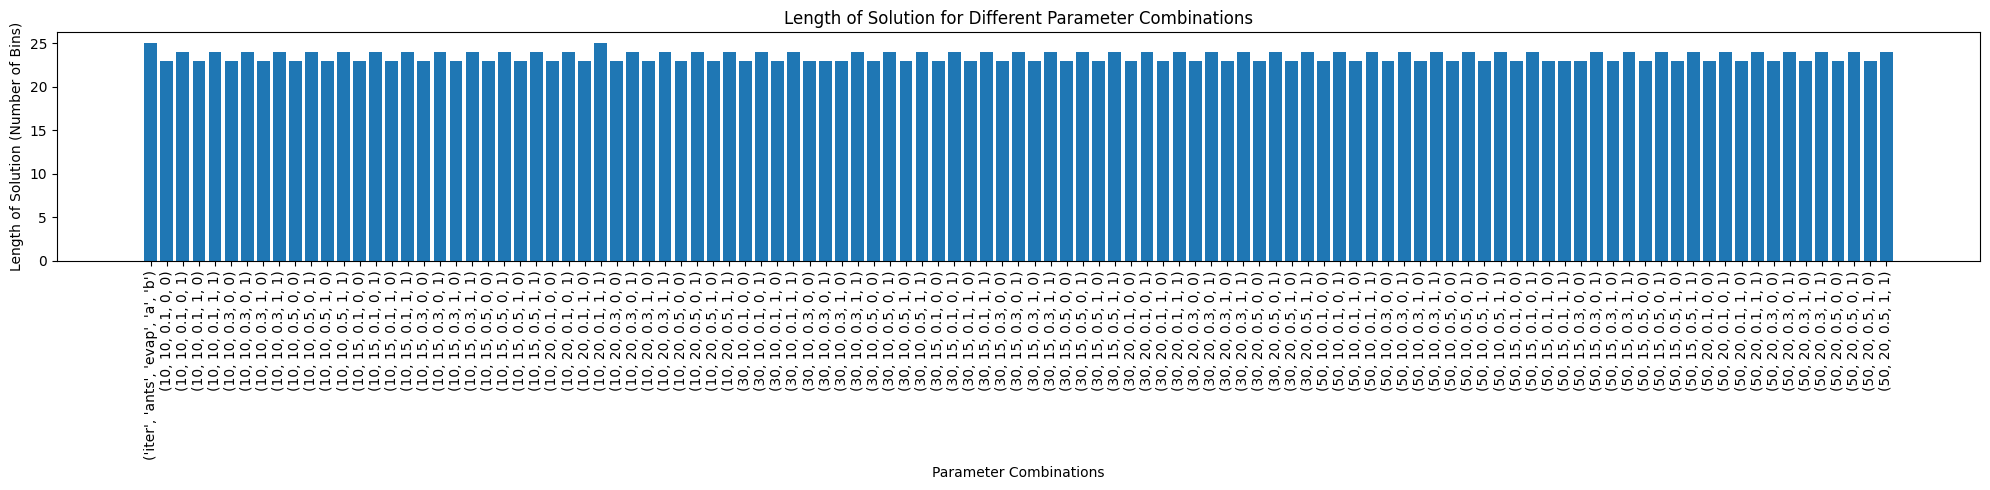

In [ ]:
    # Plot length of solution
    plt.figure(figsize=(20, 5))
    plt.bar(range(len(param_combinations)), lengths)
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Length of Solution (Number of Bins)')
    plt.title('Length of Solution for Different Parameter Combinations')
    plt.xticks(range(len(param_combinations)), param_combinations, rotation='vertical')
    plt.tight_layout()
    plt.show()

**10.Analyser le temps d'executions selon les combinisons**

Il est observé que lorsque le nombre d'itérations et le nombre de fourmis augmentent dans l'algorithme ACO, le temps d'exécution augmente également. Cette observation peut s'expliquer par le fait que chaque itération nécessite la construction de plusieurs solutions par un nombre accru de fourmis, ce qui entraîne une augmentation du temps de calcul global. De plus, avec un plus grand nombre d'itérations et de fourmis, il peut y avoir une complexité accrue dans la mise à jour des niveaux de phéromones et dans la sélection des prochaines actions, ce qui contribue également à l'augmentation du temps d'exécution. Ainsi, bien que l'augmentation du nombre d'itérations et de fourmis puisse potentiellement améliorer la qualité des solutions trouvées, il est essentiel de trouver un équilibre entre la qualité de la solution et le temps de calcul disponible dans la pratique.

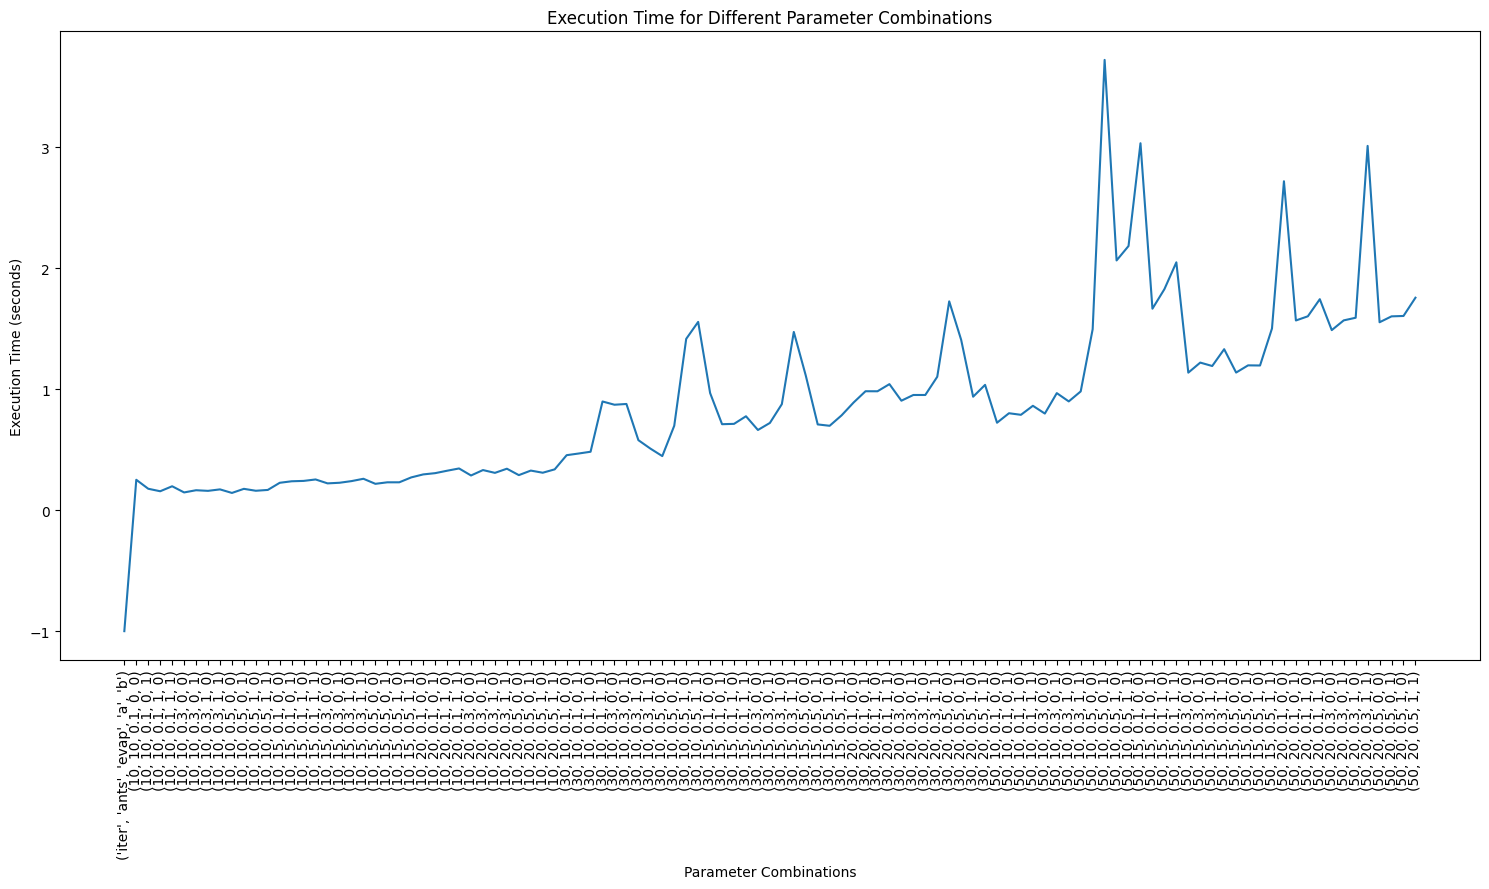

In [ ]:
    # Plot execution time
    plt.figure(figsize=(15, 9))
    plt.plot(execution_times)
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time for Different Parameter Combinations')
    plt.xticks(range(len(param_combinations)), param_combinations, rotation='vertical')
    plt.tight_layout()
    plt.show()

**11. Conclusion**


En conclusion, l'algorithme ACO émerge comme une approche robuste et performante pour résoudre le Problème de Bin Packing (PBP). Sa capacité à s'adapter aux caractéristiques spécifiques du problème et à fournir des solutions efficaces en fait un outil précieux dans divers contextes. Toutefois, il est impératif de reconnaître ses limites et de sélectionner soigneusement les paramètres pour obtenir des performances optimales. En adoptant une approche réfléchie dans la configuration des paramètres, l'ACO peut être exploité de manière efficace pour aborder différentes instances du PBP, offrant ainsi des opportunités significatives pour la résolution de problèmes réels dans divers domaines d'application.

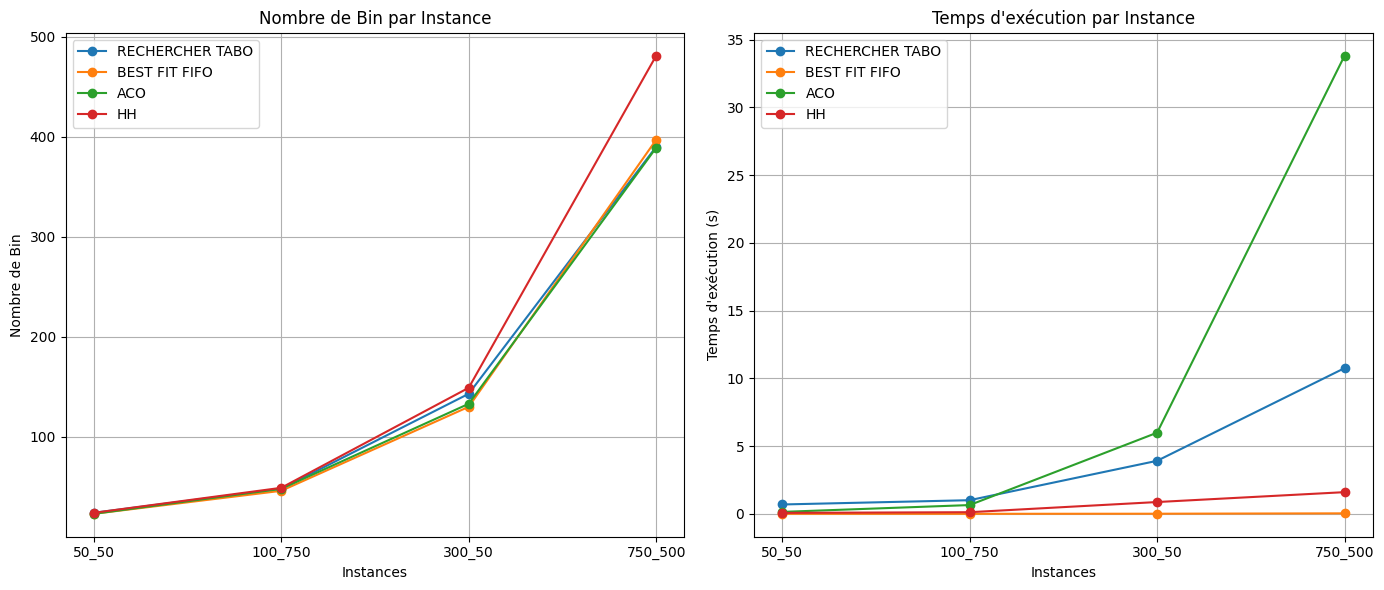

In [1]:
import matplotlib.pyplot as plt

# Data
benchmarks = ["50_50", "100_750", "300_50", "750_500"]

# Number of bins for each method
bins_rechercher_tabo = [24, 48, 143, 390]
bins_best_fifo = [23, 46, 130, 397]
bins_aco = [23, 48, 133, 389]
bins_hh = [24, 49, 149, 481]

# Execution time for each method
times_rechercher_tabo = [0.69, 1.006, 3.914036512374878, 10.755577802658081]
times_best_fifo = [0.0006, 0.0007984638214111328, 0.0082, 0.03558516502380371]
times_aco = [0.1427936553955078, 0.6465678215026855, 5.989018440246582, 33.81906247138977]
times_hh = [0.07, 0.12, 0.87, 1.6]

# Plotting Number of Bins
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(benchmarks, bins_rechercher_tabo, marker='o', label='RECHERCHER TABO')
plt.plot(benchmarks, bins_best_fifo, marker='o', label='BEST FIT FIFO')
plt.plot(benchmarks, bins_aco, marker='o', label='ACO')
plt.plot(benchmarks, bins_hh, marker='o', label='HH')
plt.title('Nombre de Bin par Instance')
plt.xlabel('Instances')
plt.ylabel('Nombre de Bin')
plt.legend()
plt.grid(True)

# Plotting Execution Time
plt.subplot(1, 2, 2)
plt.plot(benchmarks, times_rechercher_tabo, marker='o', label='RECHERCHER TABO')
plt.plot(benchmarks, times_best_fifo, marker='o', label='BEST FIT FIFO')
plt.plot(benchmarks, times_aco, marker='o', label='ACO')
plt.plot(benchmarks, times_hh, marker='o', label='HH')
plt.title("Temps d'exécution par Instance")
plt.xlabel('Instances')
plt.ylabel("Temps d'exécution (s)")
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
